Modelo Vision Transformer B/16<br>
Link para o Colab: https://colab.research.google.com/drive/1YltHY_40mkOgqgboHRx1CKcvygVqjXto#scrollTo=yNFW_O0OA003

In [ ]:
import kagglehub
from PIL import Image
import io
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import ViTImageProcessor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import os
import csv
import time

A Hugging Face (`transformers`) fornece o ViT pronto para PyTorch.

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Fixar o seed para reprodutividade
set_seed()

In [ ]:
# Download latest version
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

# Caminho para o dataset
train_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

# Carrega o parquet
df = pd.read_parquet(train_path)

Path to dataset files: /kaggle/input/alzheimer-mri-disease-classification-dataset


In [ ]:
# Label map
label_map = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

In [ ]:
# Dataset customizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]['image']['bytes']
        label = self.df.iloc[idx]['label']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Carregar o ViT pré-treinado
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Transforms com o feature_extractor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std
    )
])

In [ ]:
# Criação do dataset e dataloader
dataset = AlzheimerDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Época 1/1: 100%|██████████| 320/320 [03:01<00:00,  1.76it/s]

Loss da época 1: 1.0928


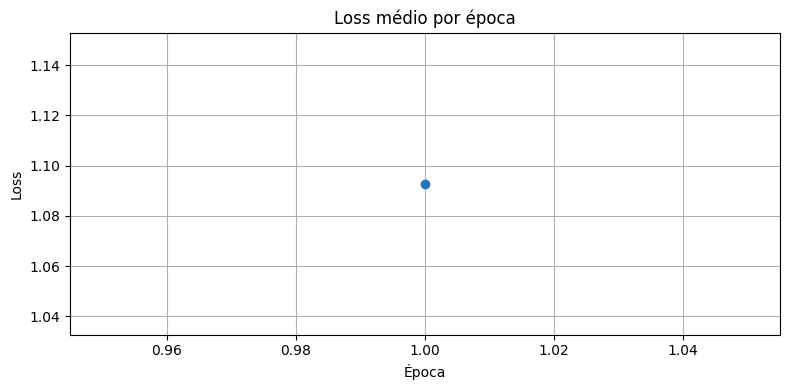

CPU times: user 3min 51s, sys: 1.13 s, total: 3min 52s
Wall time: 3min 1s


In [ ]:
%%time
# Número de exemplos por classe, na ordem dos rótulos
class_counts = torch.tensor([172, 15, 634, 459], dtype=torch.float32)

# Frequência relativa (dividido pelo total)
total = class_counts.sum()
freqs = class_counts / total

# Peso = inverso da frequência
weights = 1.0 / freqs

# Normaliza para evitar explosão de gradientes
weights = weights / weights.sum()

# Enviar para GPU
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

# Inicializa histórico
epoch_losses = []
num_epochs = 10

star_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Loop por batch
    for images, labels in tqdm(dataloader, desc=f"Época {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Média da época
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Loss da época {epoch+1}: {epoch_loss:.4f}")

end_time = time.time()
tempo_total = end_time - star_time # segundos

# Grafico por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title("Loss médio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Caminho para o arquivo de teste
test_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Lê o Parquet
df_test = pd.read_parquet(test_path)

# Cria o dataset e o dataloader de teste
test_dataset = AlzheimerDataset(df_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Coloque o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in tqdm(test_dataloader, desc="Avaliando"):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.logits, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

Avaliando: 100%|██████████| 80/80 [00:16<00:00,  4.89it/s]


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

modelo = "ViT B/16"

# Relatório completo por classe
print(f"\nModelo {modelo}")
print("\nRelatório por classe:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(4)], zero_division=0))

Acurácia: 0.5664
Precisão: 0.4678
Revocação: 0.5664
F1-score: 0.5093

Modelo ViT B/16

Relatório por classe:
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       172
 Moderate_Demented       0.00      0.00      0.00        15
      Non_Demented       0.64      0.86      0.74       634
Very_Mild_Demented       0.42      0.39      0.40       459

          accuracy                           0.57      1280
         macro avg       0.26      0.31      0.28      1280
      weighted avg       0.47      0.57      0.51      1280



In [ ]:
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred)

# Converte para DataFrame com rótulos
cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

print("Matriz de confusão:\n")
print(cm_df.to_string())

Matriz de confusão:

                    Mild_Demented  Moderate_Demented  Non_Demented  Very_Mild_Demented
Mild_Demented                   0                  0            21                 151
Moderate_Demented               0                  0             2                  13
Non_Demented                    0                  0           545                  89
Very_Mild_Demented              0                  0           279                 180


In [ ]:
resultados = {
    "modelo": modelo,
    "epocas": num_epochs,
    "tempo_total": round(tempo_total, 2), # em segundos
    "acuracia": round(accuracy, 4),
    "precisao": round(precision, 4),
    "revocacao": round(recall, 4),
    "f1_macro": round(f1, 4)
}

In [ ]:
import re
def limpar_nome_arquivo(nome):
    return re.sub(r'[\\/:"*?<>|]+', "_", nome)

nome_seguro = limpar_nome_arquivo(modelo)

In [ ]:
file_path = f"resultados_do_modelo_{nome_seguro}.csv"
campos = list(resultados.keys())

# Cria o arquivo se não existir
if not os.path.exists(file_path):
    with open(file_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writeheader()
        writer.writerow(resultados)
else:
    # Apenas adiciona nova linha
    with open(file_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writerow(resultados)